In [1]:
import numpy as np;
import cv2;
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
import pywt

- Load Testing Image

Note: In order to make image in range 0-255, I apply Min-Max Normalization.

Current Max value = 255, Min value = 0


Text(0.5, 1.0, 'Testing image')

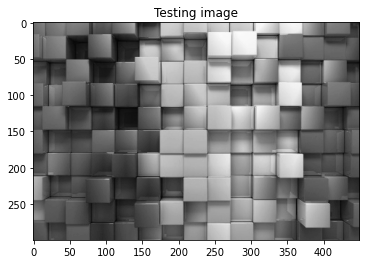

In [2]:
img = cv2.imread('colors.jpg',0)
# Min-Max Normalization: to make image in range 0-255
img = np.floor((img-(np.min(img)))/(np.max(img)-np.min(img)) * 255)
print("Current Max value = %i, Min value = %i"%(np.max(img),np.min(img)))
plt.figure()
plt.imshow(img,cmap='gray')
plt.title('Testing image')

# Problem 1 (Gaussian and Laplacian pyramids)

(a) Write functions gaussian_pyramid and laplacian_pyramid that decompose an input grayscale image into a J-level Gaussian and Laplacian pyramid, respectively, where J is an input to each function. You can use cv2.resize for downsampling and upsampling with INTER_LINEAR and INTER_CUBIC filters, respectively.

In [3]:
def gaussian_pyramid(img, j):
    res = []
    g = img
    res.append(g)
    while(j > 0):
        height = int(g.shape[0]/2)
        width = int(g.shape[1]/2)
        g = cv2.resize(g,(width,height),interpolation=cv2.INTER_LINEAR)
        res.append(g)
        j = j-1
    return res

In [4]:
def laplacian_pyramid(img, j):
    gImg = gaussian_pyramid(img, j)
    res = []
    res.append(gImg[j])
    while(j > 0):
        width = gImg[j-1].shape[1]
        height = gImg[j-1].shape[0]
        l = gImg[j-1] - cv2.resize(gImg[j],(width,height),interpolation=cv2.INTER_CUBIC)
        res.append(l)
        j = j - 1
    return res

(b) Write a function reconstruct_laplacian that reconstructs the original image from a J-level Laplacian pyramid. Verify it works correctly on a test image. Display the Gaussian and Laplacian pyramid images for J = 3.

- Display the gaussian pyramids for J = 3

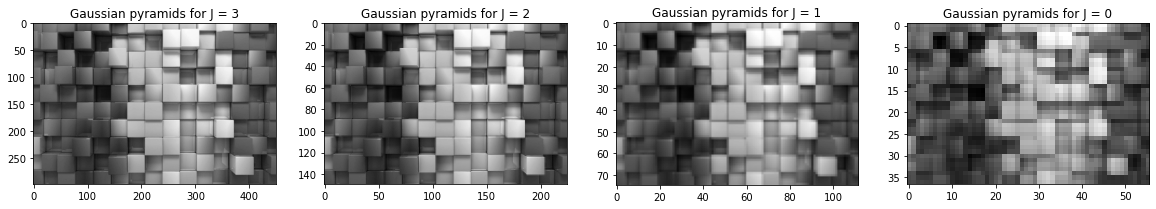

In [5]:
test_level = 3
lp = gaussian_pyramid(img, test_level)
plt.figure(figsize=(20,5))
for i,p in enumerate(lp):
    plt.subplot(1,test_level+1,i+1)
    plt.title("Gaussian pyramids for J = %i" % (test_level-i))
    plt.imshow(p, cmap = 'gray')

- Display the laplacian pyramids for J = 3

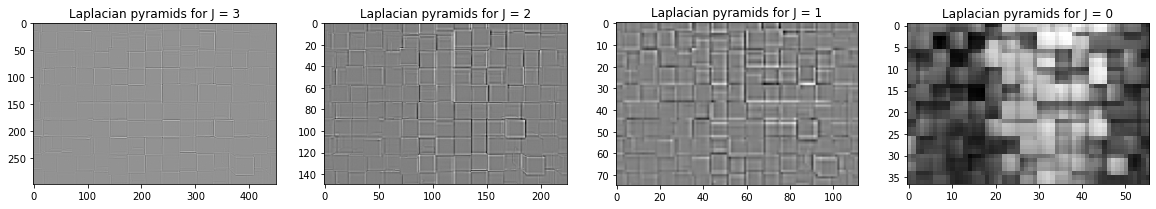

In [6]:
test_level = 3
lp = laplacian_pyramid(img, test_level)
plt.figure(figsize=(20,5))
for i in range(test_level+1):
    plt.subplot(1,test_level+1,i+1)
    plt.title("Laplacian pyramids for J = %i" % (test_level-i))
    plt.imshow(lp[test_level-i], cmap = 'gray')

- Function to reconstruct the image from a series of laplacian pyramids.

In [7]:
def reconstruct_laplacian(laplacianPyramid):
    level = len(laplacianPyramid)
    res = laplacianPyramid[0]
    for i in range(level-1):
        width = res.shape[1]*2
        height = res.shape[0]*2
        # corner case for upper level has size with odd number
        if width != laplacianPyramid[i+1].shape[1]:
            width = width + 1
        if height != laplacianPyramid[i+1].shape[0]:
            height = height + 1
        res = laplacianPyramid[i+1] + cv2.resize(res,(width, height),interpolation=cv2.INTER_CUBIC)
    return res

- Reconstruct the image from 3-level laplacian pyramid and verify the function.

Does the function successfully reconstructed the image?  True


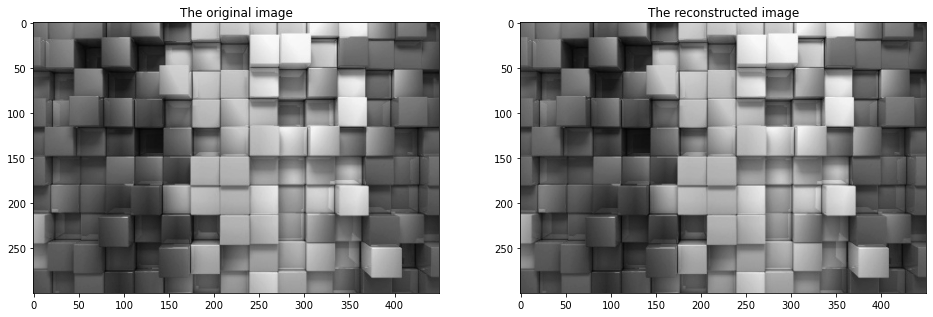

In [8]:
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
plt.title("The original image")
plt.imshow(img, cmap = 'gray')

lp = laplacian_pyramid(img, 1)
res = reconstruct_laplacian(lp)
plt.subplot(1,2,2)
plt.title("The reconstructed image")
plt.imshow(res, cmap = 'gray')
print("Does the function successfully reconstructed the image? ",(img == res).all())

The result shows that the reconstruct function perfectly reconstrcut the image from a 3-level laplacian pyramid. Which verify that my reconstruct_laplacian function is working well.

(c) Write a function quantize_pyramid that takes in a Laplacian pyramid and quantizes the coefficients c with quantization step-size q as follows,

    Q(c,q)=q*floor((c-µ)/q + 1/2)+µ

where µ is the mean of the coefficient map, assumed to be µ = 0 for residual (Laplacian) images and µ = 128 otherwise (Gaussian images).

In [9]:
def quantize_pyramid(Pyramid, q):
    # Pyramid: a series of Laplacian Pyramid, first pyramid is same as Gaussian image
    res = []
    # the first pyramid is Gaussian, so use mean = 128
    dc = q * np.floor((Pyramid[0]-128)/q+0.5) + 128 
    res.append(dc)
    level = len(Pyramid)-1
    for i in range(level):
        # rest are Laplacian Pyramid, use mean = 0
        ac = q * np.floor(Pyramid[i+1]/q+0.5)
        res.append(ac)
    return res

(d) For pyramid levels J = 0, 1, 2, 3 (where J = 0 is simply the original image) plot the reconstruction PSNR,

    PSNR=10*log10(255^2/MSE),

between the original and reconstructed image vs. the number of non-zeros in the representation for pyramids quantized at steps q = 2^n , n = 0, 1, . . . , 8. Plot PSNR on the y-axis and NNZ on the x-axis.

- Function to compute PSNR of a reconstructed image

In [10]:
def get_psnr(ogimg,image):
    # ignore the warning info when calculate MSE
    warnings.filterwarnings('ignore')
    mse = mean_squared_error(ogimg,image)
    res = 10 * np.log10(255**2/mse)
    return res

- Function to compute the number of non-zero pixel(NNZ) of laplacian pyramids.

In [11]:
def get_NNZ(pyramids):
    # compute NNZ of a series of pyramid
    level = len(pyramids)
    count = 0
    for i in range(level):
        count += np.count_nonzero(pyramids[i])
    return count

- Plot the relation betweent the PSNR and the NNZ of reconstructed image at different quantization level.

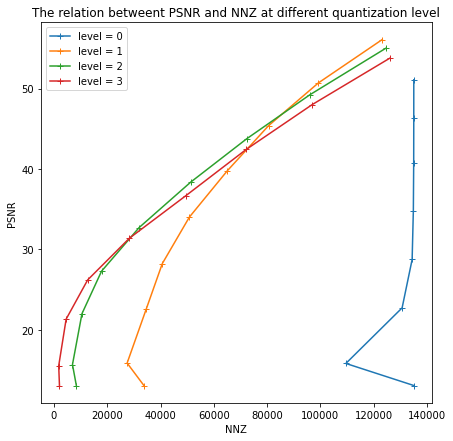

In [12]:
j_level = [0,1,2,3]
step_all = 2**np.arange(0,9)
plt.figure(figsize=(7,7))
for j in j_level:
    lp = laplacian_pyramid(img, j)
    nnz_all = []
    psnr_all = []
    
    for s in step_all:
        # compute NNZ
        quantized_pyramid = quantize_pyramid(lp,s)
        reconstructImg = reconstruct_laplacian(quantized_pyramid)
        # plt.figure()
        # plt.imshow(reconstructImg,cmap='gray')
        nnz = get_NNZ(quantized_pyramid)
        nnz_all.append(nnz)
        # compute PSNR
        psnr = get_psnr(img, reconstructImg)
        psnr_all.append(psnr)

    # plot
    label = 'level = ' + str(j) + ''
    plt.plot(nnz_all, psnr_all,'+-',label=label)
plt.title('The relation betweent PSNR and NNZ at different quantization level')
plt.xlabel('NNZ')
plt.ylabel('PSNR')
plt.legend()

- What relationship do you observe between pyramid depth and representation efficiency for a desired reconstruction PSNR? Is this expected?

The overall conclusion is not very clear, so I discuss the results in three cases:

1. If we try to reach a reconstructed PSNR over 50, the deeper the pyramid depth is, the higher number of non-zero pixel we need. Which means that to reach a high PSNR (over 50), a lower pyramids level will have greater representation efficiency.
2. But if we only try to reach a PSNR at about 20-30, the deeper the pyramid depth is, the lower number of non-zero pixel we need. Which means that to reach a 20-30 PSNR, a higher pyramids level will have greater representation efficiency.
3. For reconstructed PSNR at 30-50, the relation between pyramid depth and representation efficiency is not so clear.

(e) For J = 3, determine qualitatively at what point the quantization level is unnoticeable. How do the number of non-zeros compare to the original image?

The NNZ of original image = 134998
For J=3:
When step size(q) = 1, PSNR = 53.7814, nnz = 126029, nnz percentage = 93.36%;
When step size(q) = 2, PSNR = 48.0069, nnz = 96902, nnz percentage = 71.78%;
When step size(q) = 4, PSNR = 42.4268, nnz = 72130, nnz percentage = 53.43%;
When step size(q) = 8, PSNR = 36.6812, nnz = 49512, nnz percentage = 36.68%;
When step size(q) = 16, PSNR = 31.3962, nnz = 28342, nnz percentage = 20.99%;
When step size(q) = 32, PSNR = 26.2010, nnz = 12653, nnz percentage = 9.37%;
When step size(q) = 64, PSNR = 21.3259, nnz = 4576, nnz percentage = 3.39%;
When step size(q) = 128, PSNR = 15.5255, nnz = 1787, nnz percentage = 1.32%;
When step size(q) = 256, PSNR = 13.0712, nnz = 2072, nnz percentage = 1.53%;


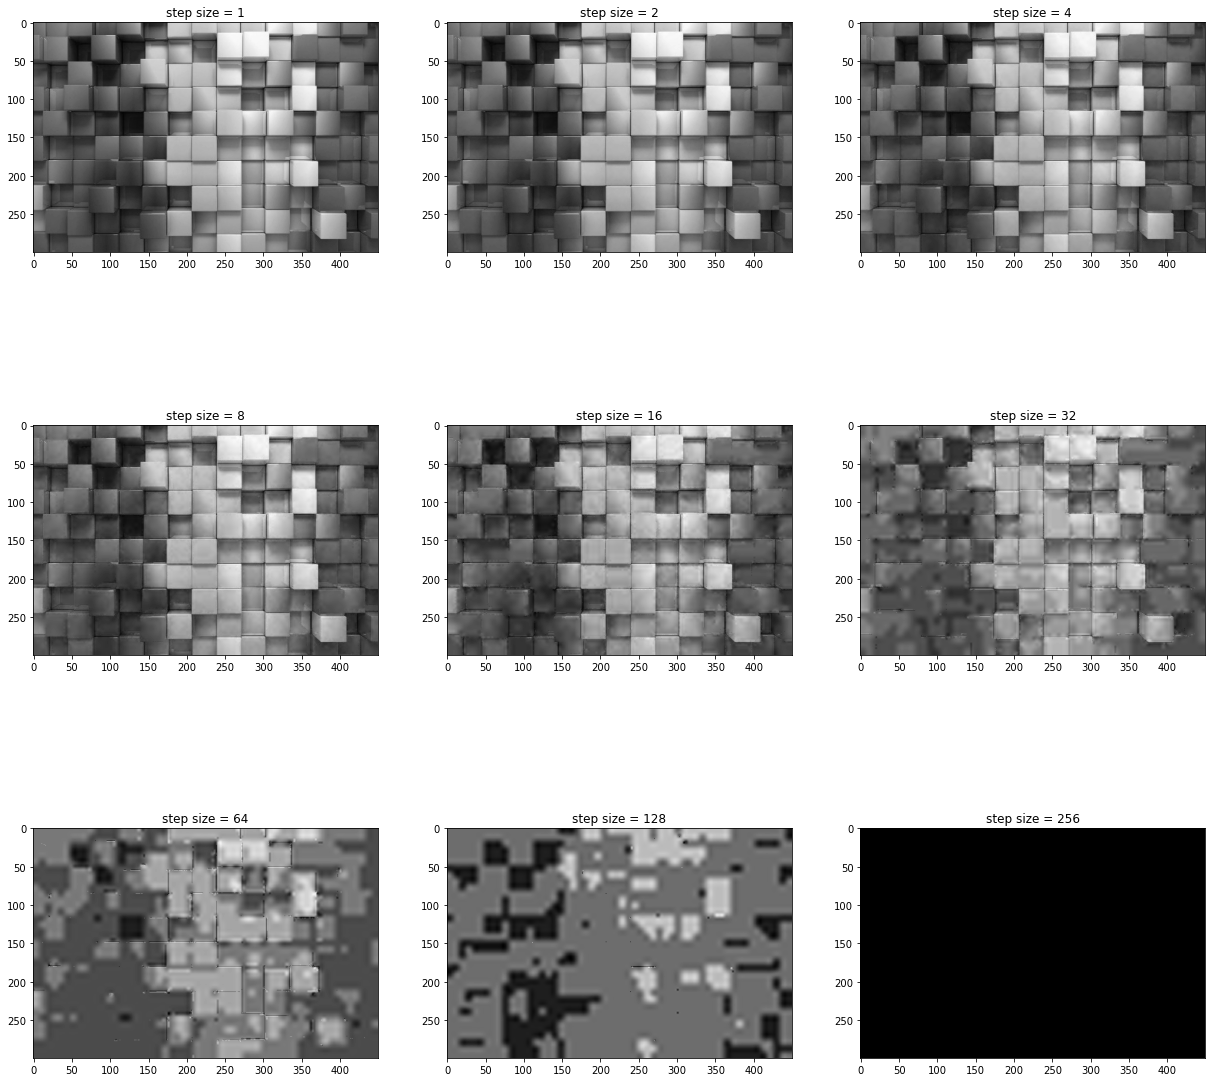

In [13]:
nnz_og = np.count_nonzero(img)
print("The NNZ of original image = %i" % nnz_og)
lp = laplacian_pyramid(img, 3)
step_all = 2**np.arange(0,9)
print("For J=3:")
plt.figure(figsize=(21,21))
for i,s in enumerate(step_all):
    quantized_pyramid = quantize_pyramid(lp,s)
    reconstructImg = reconstruct_laplacian(quantized_pyramid)
    plt.subplot(3,3,i+1)
    plt.imshow(reconstructImg,cmap='gray')
    plt.title("step size = %i" % s)
    nnz = get_NNZ(quantized_pyramid)
    nnz_percent = nnz/nnz_og*100
    psnr = get_psnr(img, reconstructImg)
    print("When step size(q) = %i, PSNR = %.4f, nnz = %i, nnz percentage = %.2f%%;" %(s,psnr,nnz,nnz_percent))

- Answer:

From the result and images showing above, the "blocky" part is gradually visible to the naked eye starting from the image with a quantization level at steps = 16. But at steps = 8, the condition of reconstructed image is still looks good.

Therefore, I would like to say the quantization level at steps = 8 is still unnoticeable. The NNZ at steps = 8 is 49512, which is only 36.68% of original image's NNZ. And the reconstructed image can reach a good condition that PSNR = 36.6812.

# Problem 2 (Wavelet Transform)

(a) Use PyWavelet’s dwt2 and idwt2 to write J-level wavelet transform (wavelet_transform) and reconstruction (reconstruct_wavelet) functions, for a grayscale input image. Use symmetric boundary conditions.

- Function to do wavelet transfrom, the output is a series of wavelets in form of (LL,(LH,HL,HH), ...)

In [14]:
def wavelet_transform(img, j):
    cur = img
    if j == 0:
        return img
    else:
        res = pywt.dwt2(img,wavelet='haar',mode='symmetric')
        LL = res[0]
        j = j-1
    while (j>0):
        cur = pywt.dwt2(LL,wavelet='haar',mode='symmetric')
        res = cur + res[1:]
        LL = cur[0]
        j = j - 1
    return res

- Function to assemble all subimage into a single image

Note: I normalized all subimages by scaling all of them to 0-1 since the data range of different subimages is different.

In [15]:
def assemble(res):
    # wavelet is in form of (LL,(LH,HL,HH), ...)
    level = len(res) - 1
    h = res[0].shape[0]
    w = res[0].shape[1]
    for i in range(level):
        h = h + res[i+1][0].shape[0]
        w = w + res[i+1][0].shape[1]
    output = np.zeros((h,w))
    hh = res[0].shape[0]
    ww = res[0].shape[1]
    output[0:hh,0:ww] = (res[0]-np.min(res[0]))/(np.max(res[0])-np.min(res[0]))
    ch = hh
    cw = ww
    for i in range(level):
        for j in range(3):
            cur = res[i+1][j]
            hh = cur.shape[0]
            ww = cur.shape[1]
            if j == 0:  
                output[ch:ch+hh,0:ww] = (cur-np.min(cur))/(np.max(cur)-np.min(cur))
            if j == 1:
                output[0:hh,cw:cw+ww] = (cur-np.min(cur))/(np.max(cur)-np.min(cur))
            if j == 2:
                output[ch:ch+hh,cw:cw+ww] = (cur-np.min(cur))/(np.max(cur)-np.min(cur))
        ch = ch + hh
        cw = cw + ww
    return output

- Assemble subimage

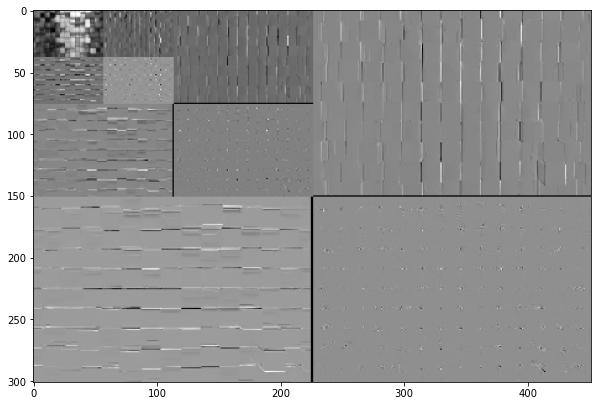

In [16]:
res = wavelet_transform(img,3)
output = assemble(res)
plt.figure(figsize=(10,10))
plt.imshow(output,cmap='gray')

- The black line in the middle is because the subimage has a odd size. So after doing wavelet transform, the width/height of subimage is not perfectly equal to width/2 or height/2 of the original image. But it does not affect the reconstruction and quantization of the image.

- Plot image in different part

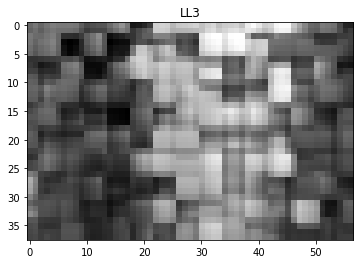

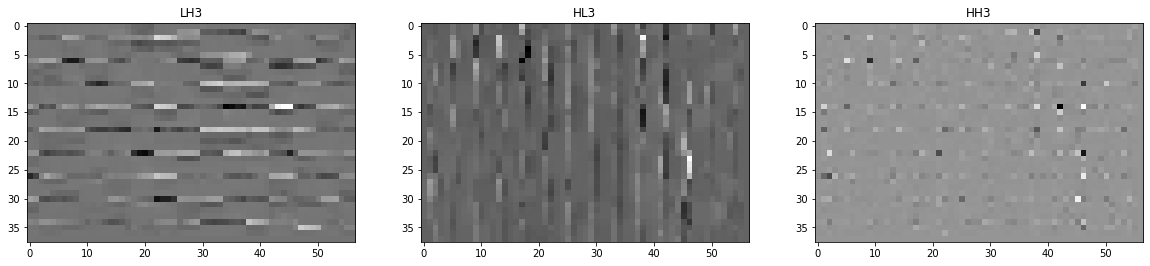

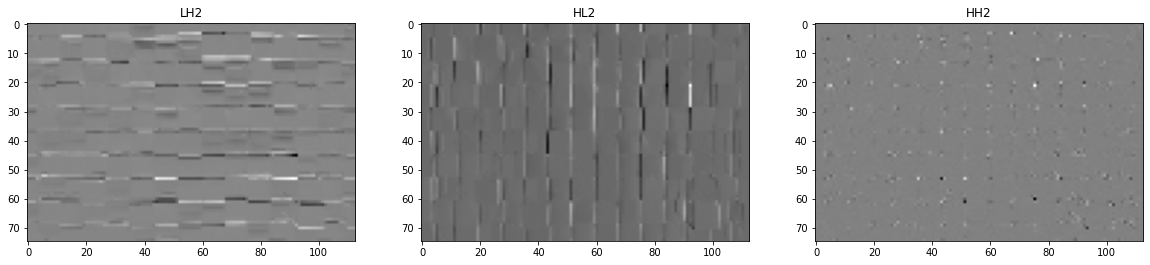

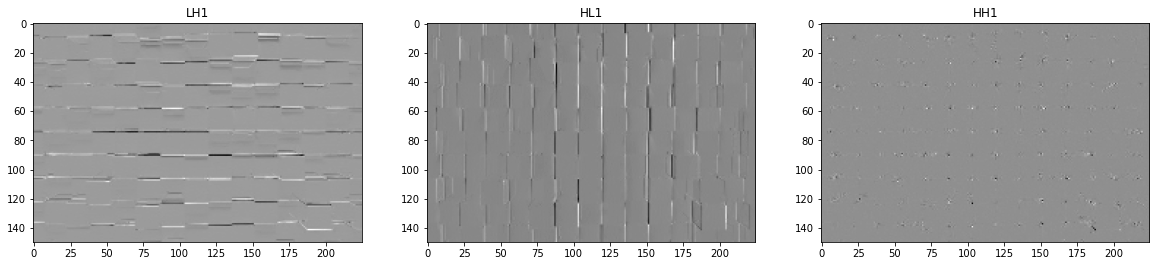

In [17]:
res = wavelet_transform(img,3)
title = ["LH","HL","HH"]
for i in range(4):
    if(i == 0):
        plt.figure()
        plt.title("LL3")
        plt.imshow(res[i],cmap = 'gray')
        continue
    plt.figure(figsize=(20,5))
    for j in range(3):
        plt.subplot(1,3,j+1)
        plt.title(title[j]+str(4-i))
        plt.imshow(res[i][j],cmap = 'gray')


(b) Repeat parts (b,c,d,e) from problem 1, now with your wavelet transform functions and wavelet subimages.

!! Note: Since I already display a 3-level wavelet in the previous part, so I didn't plot it again in this part.

- Function to reconstructs the image from J-level wavelet.

In [18]:
def reconstruct_wavelet(wave):
    # wavelet is in form of (LL,(LH,HL,HH), ...)
    if type(wave) != tuple:
        return wave
    level = len(wave) - 1
    LL = wave[0]
    for i in range(level):
        others = wave[i+1]
        if LL.shape[0] != others[0].shape[0]:
            LL = LL[:-1,:]
        if LL.shape[1] != others[0].shape[1]:
            LL = LL[:,:-1]
        (cA,(cH,cV,cD)) = (LL, others)
        LL = pywt.idwt2((cA,(cH,cV,cD)),wavelet='Haar',mode='symmetric')
    return LL

- Reconstruct the image from 3-level wavelet pyramid and verify the function.

Does the function successfully reconstructed the image?  False
The PSNR of the reconstructed image = 307.429


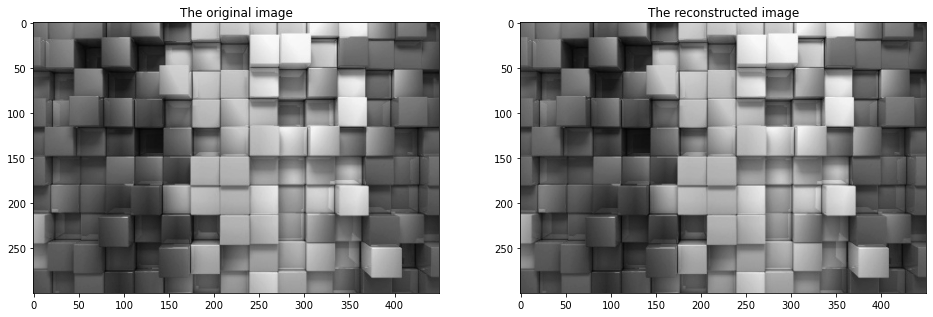

In [19]:
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
plt.title("The original image")
plt.imshow(img, cmap = 'gray')

wave = wavelet_transform(img,3)
res = reconstruct_wavelet(wave)
psnr = get_psnr(img, res)
plt.subplot(1,2,2)
plt.title("The reconstructed image")
plt.imshow(res,cmap = 'gray')
print("Does the function successfully reconstructed the image? ",(img == res).all())
print("The PSNR of the reconstructed image = %.3f" % psnr)

We can see that the PSNR of the reconstructed image is over 300, so we can consider it as perfectly reconstructed.

- Observe the relation between wavelet level and the reconstructed PSNR.

Text(0.5, 1.0, "The reconstucted image's PSNR at different wavelet level (without quantization)")

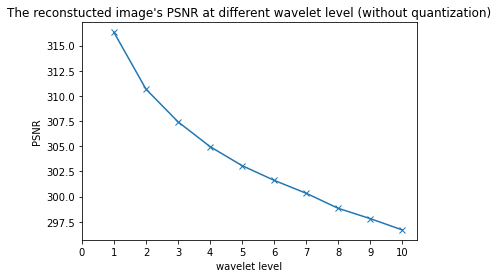

In [20]:
j_level = [0,1,2,3,4,5,6,7,8,9,10]
psnr_all = []
for j in j_level:
    wave = wavelet_transform(img, j)
    reconstructImg = reconstruct_wavelet(wave)
    psnr = get_psnr(img,reconstructImg)
    psnr_all.append(psnr)
plt.figure()
plt.plot(psnr_all,'x-')
plt.xticks(j_level)
plt.xlabel('wavelet level')
plt.ylabel('PSNR')
plt.title("The reconstucted image's PSNR at different wavelet level (without quantization)")

From the result showing above, We can see that the reconstructed PSNR are all very high (about 300) in different wavelet levels. Which verify that my reconstruct_wavelet function is working well.

- Function for wavelet quantization

In [21]:
def quantize_wavelet(wavelet, q):
    # wavelet is in form of (LL,(LH,HL,HH),...)
    
    # Corner case: when wavelet level = 0, the input image is original image
    if type(wavelet) != tuple:
        res = np.floor((wavelet-128)/q+0.5)*q + 128
        return res
    
    level = len(wavelet) - 1
    res = []
    dc = wavelet[0]
    # Because every time do wavelet, the data range in LL mutiply by 2, 
    # So we need firstly divide 2**J for dc part to make this part in range 0-255
    dc = dc/(2**level)
    dc = np.floor((dc-128)/q+0.5)*q + 128
    # for reconstruct the image in the future, we multiply 2**J for dc to recover its original data range
    dc = dc*(2**level)
    res.append(dc)

    for i in range(level):
        ac = []
        for j in range(3):
            cur = wavelet[i+1][j]
            cur = np.floor(cur/q+0.5)*q
            ac.append(cur)
        res.append(tuple(ac))
    return tuple(res)

- Plot and observe the relation betweent the reconstructed image's PSNR and NNZ at different quantization level

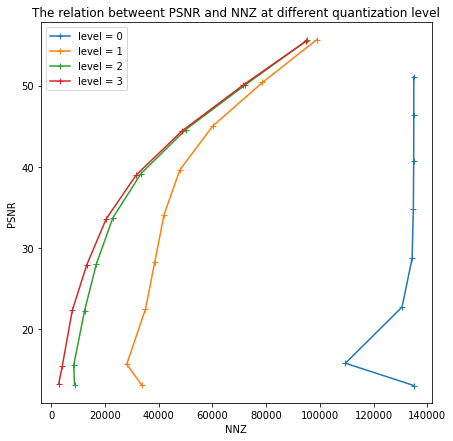

In [22]:
j_level = [0,1,2,3]
step_all = 2**np.arange(0,9)
plt.figure(figsize=(7,7))
for j in j_level:
    wave = wavelet_transform(img, j)
    nnz_all = []
    psnr_all = []

    for s in step_all:
        # compute NNZ
        quantized_wave = quantize_wavelet(wave,s)
        reconstructImg = reconstruct_wavelet(quantized_wave)
        nnz = get_NNZ(quantized_wave)
        nnz_all.append(nnz)
        # compute PSNR
        psnr = get_psnr(img, reconstructImg)
        psnr_all.append(psnr)
    
    # plot
    label = 'level = ' + str(j) + ''
    plt.plot(nnz_all, psnr_all,'+-',label=label)
plt.title('The relation betweent PSNR and NNZ at different quantization level')
plt.xlabel('NNZ')
plt.ylabel('PSNR')
plt.legend()

What relationship do you observe between pyramid depth and representation efficiency for a desired reconstruction PSNR? Is this expected?

- From the plot we can see that, to reach same reconstruction PSNR value, 3-level wavelet have the least number of non-zero pixel(NNZ), 2-level wavelet have midium number of non-zero pixel(NNZ), 1-level wavelet have the most number of non-zero pixel(NNZ). So, we can say that the higher wavelet level is, the higher repersentation efficiency for a desired reconstruction PSNR it will have.
- The difference of representation efficiency between different wavelet level becomes smaller as the PSNR need to be reach become higher.
- To reach a same PSNR level, the difference of NNZ between 3-level wavelet and 2-level wavelet < the difference of NNZ between 2-level wavelet and 1-level wavelet < the difference of NNZ between 1-level wavelet and 0-level wavelet. Which can be conclude that to reach a same PSNR level, the difference of representation effeciency between n+1 level wavelet and n-level wavelet decrease with increasing n.

For J = 3, determine qualitatively at what point the quantization level is unnoticeable. How do the number of non-zeros compare to the original image?

The NNZ of original image = 134998
For J=3:
When step size(q) = 1, PSNR = 55.4883, nnz = 94990, nnz percentage = 70.36%;
When step size(q) = 2, PSNR = 50.0705, nnz = 71490, nnz percentage = 52.96%;
When step size(q) = 4, PSNR = 44.4505, nnz = 48803, nnz percentage = 36.15%;
When step size(q) = 8, PSNR = 38.9950, nnz = 31602, nnz percentage = 23.41%;
When step size(q) = 16, PSNR = 33.5850, nnz = 20405, nnz percentage = 15.12%;
When step size(q) = 32, PSNR = 27.8901, nnz = 13129, nnz percentage = 9.73%;
When step size(q) = 64, PSNR = 22.3243, nnz = 7777, nnz percentage = 5.76%;
When step size(q) = 128, PSNR = 15.4613, nnz = 4036, nnz percentage = 2.99%;
When step size(q) = 256, PSNR = 13.2814, nnz = 2712, nnz percentage = 2.01%;


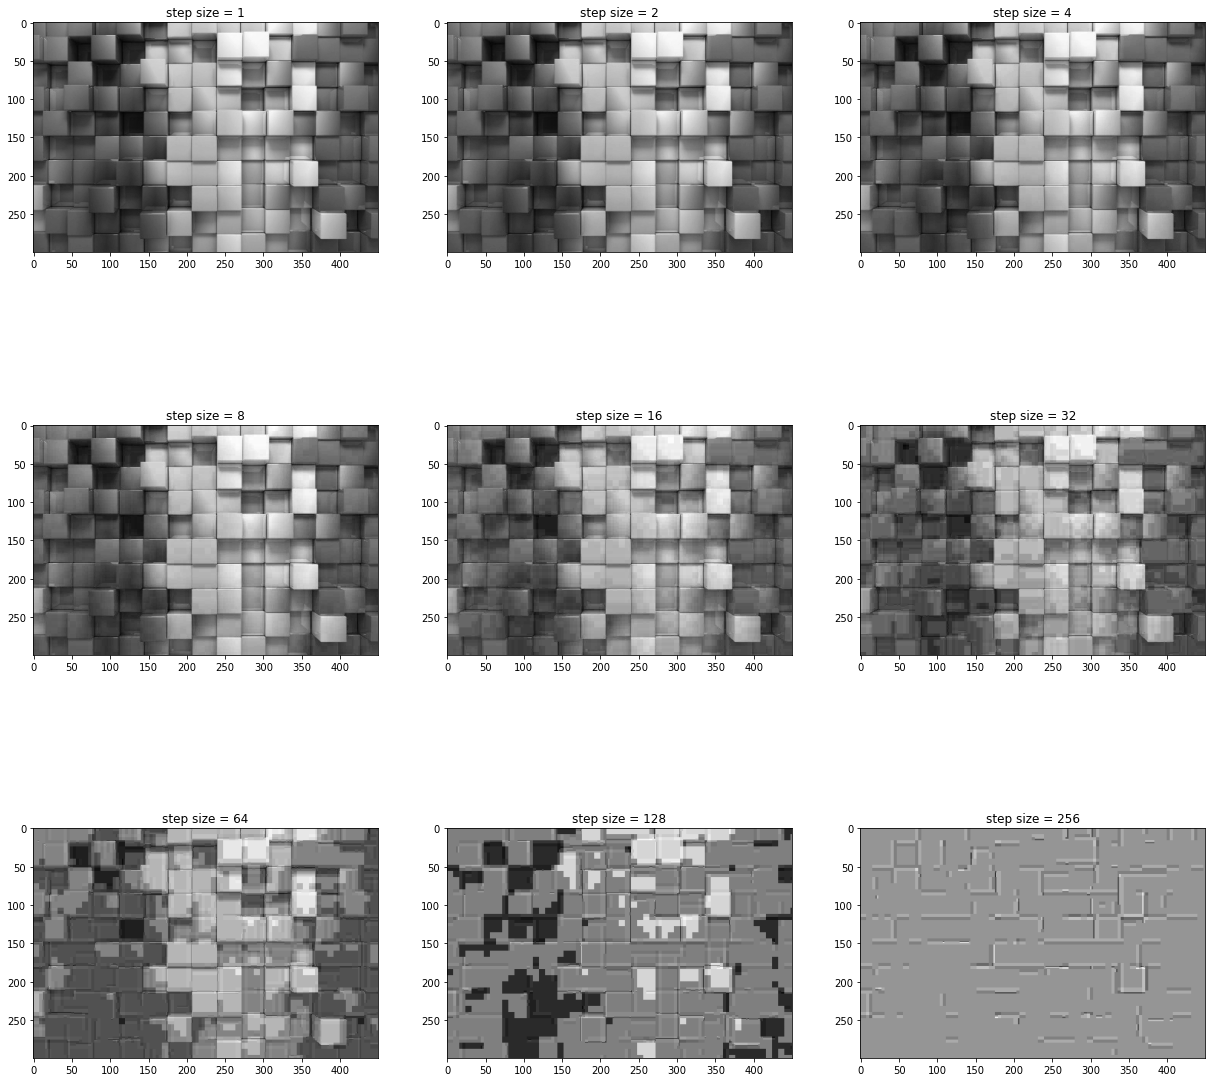

In [23]:
nnz_og = np.count_nonzero(img)
print("The NNZ of original image = %i" % nnz_og)
wave = wavelet_transform(img, 3)
step_all = 2**np.arange(0,9)
print("For J=3:")
plt.figure(figsize=(21,21))
for i,s in enumerate(step_all):
    quantized_wave = quantize_wavelet(wave,s)
    reconstructImg = reconstruct_wavelet(quantized_wave)
    plt.subplot(3,3,i+1)
    plt.imshow(reconstructImg,cmap='gray')
    plt.title("step size = %i" % s)
    nnz = get_NNZ(quantized_wave)
    nnz_percent = nnz/nnz_og*100
    psnr = get_psnr(img, reconstructImg)
    print("When step size(q) = %i, PSNR = %.4f, nnz = %i, nnz percentage = %.2f%%;" %(s,psnr,nnz,nnz_percent))

- Answer:

From the result and images showing above, the "blocky" part is gradually visible to the naked eye starting from the image with a quantization level at steps = 16. But at steps = 8, the condition of reconstructed image is still looks great.

Therefore, I would like to say the quantization level at steps = 8 is still unnoticeable. The NNZ at steps = 8 is 31602, which is only 23.41% of original image's NNZ. And the reconstructed image can reach a good condition that PSNR = 38.9950.

(c) Based on your results, compare the representation efficiency of the Laplacian pyramid and wavelet transform in terms of the NNZ required to represent an image to the same quality (PSNR).

From the result showing above, we can see that to reach PSNR = 36.6812, by using laplacian transform we need nnz = 49512, which is 36.68% of the original image; However, if we use wavelet transform, to reach PSNR = 38.9950, which is approximately equal to the PSNR of the laplacian transform example (actually, is higher), we only need nnz = 31602, which is only 23.41% of the original image. Using wavelet transform need less non-zero pixel to reach a same desireable quality. 

Therefore, we can say that to reach the same quality, using wavelet transform have greater repersentation efficiency than using laplacian transform.